<a href="https://colab.research.google.com/github/neelkanthrawat/mlph2023-Exercises/blob/main/Copy_of_sheet05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sheet 5

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn

# 2) Phase classification in $\phi^4$ theory

(a)

In [2]:
train = np.load('/content/lattice_train.npy')#np.load("data05/lattice_train.npy")
test = np.load('/content/lattice_test.npy')#np.load("data05/lattice_test.npy")
kappa = np.arange(0.24, 0.30, 0.0025)

L = 16
lattice_shape = (L,L)

train, test = torch.tensor(train), torch.tensor(test)
symmetric_phase_data, broken_phase_data = train[0,...], train[1,...]

In [3]:
train.shape, test.shape

(torch.Size([2, 1000, 16, 16]), torch.Size([24, 100, 16, 16]))

In [4]:
## let;s consider the first configuration for the broken and unbroken phase
train[0,:,:,:].shape, train[1,:,:,:].shape

(torch.Size([1000, 16, 16]), torch.Size([1000, 16, 16]))

In [5]:
test.shape[0]

24

In [6]:
(0.3-0.24)/test.shape[0]

0.0025

In [7]:
0.24+ (24*0.0025)

0.3

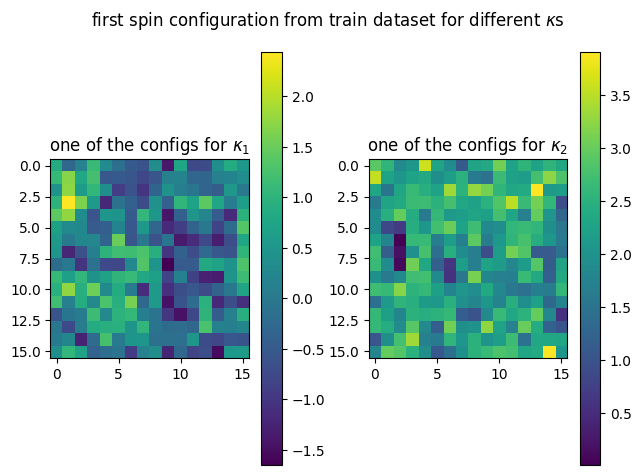

In [8]:
# TODO: Visualize lattice sides for different values of kappa
plt.suptitle(r"first spin configuration from train dataset for different $\kappa$s")
plt.subplot(1,2,1)
plt.imshow(train[0,0,:,:])
plt.colorbar()
plt.title(r'one of the configs for $\kappa_{1}$')# unbroken phase

plt.subplot(1,2,2)
plt.imshow(train[1,0,:,:])
plt.colorbar()
plt.title(r'one of the configs for $\kappa_{2}$')# broken phase
plt.tight_layout()
plt.show()

In [9]:
# #### plotting the test data
# num_kappas_test = test.shape[0]
# delta_kappa = (0.3 - 0.24) / (num_kappas_test-1)
# print("delta_kappa:",delta_kappa)


# # let's plot first 5 configurations of different kappas.
# #for plots in range(0,1):# for the time being, let;s plot only the first configuration for all different kappas
# fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(12, 8))
# config_num=1
# plt.suptitle(f"plotting the {config_num+1}'th spin configuration from test dataset for different $\kappa$s")
# for i in range(0, num_kappas_test):
#   data = test[i, config_num, :, :]
#   # axes.flatten()[i].imshow(data, cmap='viridis')
#   im = axes.flatten()[i].imshow(data, cmap='viridis')
#   axes.flatten()[i].set_title(f"kappa_{i + 1}={np.round(0.24+i*delta_kappa,3)}",fontsize=8)  # Set subplot title
#   plt.colorbar(im, ax=axes.flatten()[i])

#   # Adjust layout to prevent clipping of titles
#   plt.tight_layout()

#     # Show the plot
# plt.show()

(b)

In [71]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

class CNNModel(nn.Module):
    def __init__(self, nf=16):
        """
        Initialize the CNNModel.

        Parameters:
        - nf (int): Number of filters for the first convolutional layer.
        """
        super(CNNModel, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(1, nf, kernel_size=5, stride=1, padding=1)
        # Convolutional layer with 1 input channel, nf output channels, 4x4 kernel, and padding to maintain spatial dimensions.

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Max pooling layer with a 2x2 kernel and stride 2 for downsampling.

        # Number of output channels for the second convolutional layer is set to nf for simplicity
        nf_out_conv2 = nf
        self.conv2 = nn.Conv2d(nf, nf_out_conv2, kernel_size=8, stride=1, padding=1)
        # Convolutional layer with nf output channels from conv1, nf_out_conv2 output channels, 4x4 kernel, and padding.


        # Store nf as an instance variable
        self.nf = nf

        ### Fully connected layers
        self.fc1 = nn.Linear(3, 128)# we have later changed the numebr of input params for this layer
        # Fully connected layer with dynamically calculated input features and 128 output features.

        self.fc2 = nn.Linear(128, 128)
        # Additional fully connected layer with 128 input features.

        self.fc3 = nn.Linear(128, 128)
        # Fully connected layer with 64 input features.

        self.fc4 = nn.Linear(128, 1)
        # Fully connected layer with 1 output feature for binary classification.



    def forward(self, x):
      x = F.leaky_relu(self.conv1(x))
      print(f"conv1 output size: {x.size()}")
      print("_"*20)
      print(f"conv1 weight norm: {self.conv1.weight.norm().item()}")
      print(f"conv1 bias norm: {self.conv1.bias.norm().item()}")

      x = self.pool(x)
      print(f"pool output size: {x.size()}")

      x = F.leaky_relu(self.conv2(x))
      print(f"conv2 output size: {x.size()}")
      print(f"conv2 weight norm: {self.conv2.weight.norm().item()}")
      print(f"conv2 bias norm: {self.conv2.bias.norm().item()}")

      height, width = x.size()[2], x.size()[3]
      x = x.view(x.size(0), -1)
      print(f"flattened output size: {x.size()}")

      self.fc1.in_features = self.nf * height * width
      self.fc1 = nn.Linear(self.nf * height * width, 128)

      x = F.leaky_relu(self.fc1(x))
      print(f"fc1 output size: {x.size()}")
      print(f"fc1 weight norm: {self.fc1.weight.norm().item()}")
      print(f"fc1 bias norm: {self.fc1.bias.norm().item()}")

      x = F.leaky_relu(self.fc2(x))
      print(f"fc2 output size: {x.size()}")
      print(f"fc2 weight norm: {self.fc2.weight.norm().item()}")
      print(f"fc2 bias norm: {self.fc2.bias.norm().item()}")

      x = F.leaky_relu(self.fc3(x))
      print(f"fc3 output size: {x.size()}")
      print(f"fc3 weight norm: {self.fc3.weight.norm().item()}")
      print(f"fc3 bias norm: {self.fc3.bias.norm().item()}")

      x = torch.sigmoid(self.fc4(x))
      print(f"fc4 output size: {x.size()}")
      print(f"fc4 weight norm: {self.fc4.weight.norm().item()}")
      print(f"fc4 bias norm: {self.fc4.bias.norm().item()}")

      return x

In [94]:
import torch.nn.init as init

# class CNNModel2(nn.Module):
#     def __init__(self, nf=8):
#         super(CNNModel2, self).__init__()

#         # Convolutional layers
#         self.conv1 = nn.Conv2d(1, nf, kernel_size=2, stride=1, padding=1)
#         self.bn1 = nn.BatchNorm2d(nf)  # Batch Normalization after conv1
#         self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

#         nf_out_conv2 = nf
#         self.conv2 = nn.Conv2d(nf, nf_out_conv2, kernel_size=2, stride=1, padding=1)
#         self.bn2 = nn.BatchNorm2d(nf_out_conv2)  # Batch Normalization after conv2

#         # Add two more convolutional layers
#         self.conv3 = nn.Conv2d(nf_out_conv2, nf_out_conv2, kernel_size=2, stride=1, padding=1)
#         self.bn3 = nn.BatchNorm2d(nf_out_conv2)  # Batch Normalization after conv3

#         self.conv4 = nn.Conv2d(nf_out_conv2, nf_out_conv2, kernel_size=2, stride=1, padding=1)
#         self.bn4 = nn.BatchNorm2d(nf_out_conv2)  # Batch Normalization after conv4

#         self.nf = nf

#         # Fully connected layers
#         self.fc1 = nn.Linear(3, 128)
#         self.bn_fc1 = nn.BatchNorm1d(128)  # Batch Normalization after fc1
#         self.fc2 = nn.Linear(128, 1)

#         # Weight Initialization
#         for layer in [self.conv1, self.conv2, self.conv3, self.conv4, self.fc1, self.fc2]:
#             if hasattr(layer, 'weight'):
#                 init.xavier_normal_(layer.weight)

#     def forward(self, x):
#         x = F.leaky_relu(self.bn1(self.conv1(x)))
#         print("_"*20)

#         x = self.pool(x)

#         x = F.leaky_relu(self.bn2(self.conv2(x)))

#         # Add two more convolutional layers
#         x = F.leaky_relu(self.bn3(self.conv3(x)))
#         x = F.leaky_relu(self.bn4(self.conv4(x)))

#         height, width = x.size()[2], x.size()[3]
#         x = x.view(x.size(0), -1)

#         self.fc1.in_features = self.nf * height * width
#         self.fc1 = nn.Linear(self.nf * height * width, 128)
#         x = F.leaky_relu(self.bn_fc1(self.fc1(x)))

#         x = torch.sigmoid(self.fc2(x))

#         return x


############# somewhat of a better performance
# import torch.nn.functional as F
# from torch.nn import init
# import torch.nn as nn

# import torch.nn.functional as F
# from torch.nn import init
# import torch.nn as nn

# class CNNModel2(nn.Module):
#     def __init__(self, nf=8):
#         super(CNNModel2, self).__init__()

#         # Convolutional layers
#         self.conv1 = nn.Conv2d(1, nf, kernel_size=6, stride=1, padding=1)
#         self.bn1 = nn.BatchNorm2d(nf, momentum=0.1)

#         self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

#         nf_out_conv2 = nf
#         self.conv2 = nn.Conv2d(nf, nf_out_conv2, kernel_size=5, stride=1, padding=1)
#         self.bn2 = nn.BatchNorm2d(nf_out_conv2, momentum=0.1)

#         # Add two more convolutional layers
#         self.conv3 = nn.Conv2d(nf_out_conv2, nf_out_conv2, kernel_size=4, stride=1, padding=1)
#         self.bn3 = nn.BatchNorm2d(nf_out_conv2, momentum=0.1)

#         self.conv4 = nn.Conv2d(nf_out_conv2, nf_out_conv2, kernel_size=3, stride=1, padding=1)
#         self.bn4 = nn.BatchNorm2d(nf_out_conv2, momentum=0.1)

#         self.nf = nf

#         # Fully connected layers
#         self.fc1 = nn.Linear(3, 64)
#         self.bn_fc1 = nn.BatchNorm1d(64, momentum=0.1)

#         self.fc2 = nn.Linear(64, 1)

#         # Weight Initialization
#         for layer in [self.conv1, self.conv2, self.conv3, self.conv4, self.fc1, self.fc2]:
#             if hasattr(layer, 'weight'):
#                 init.xavier_normal_(layer.weight)

#     def forward(self, x):
#         print(f"Shape before conv1: {x.shape}")

#         x = F.leaky_relu(self.bn1(self.conv1(x)))
#         print(f"Shape after conv1: {x.shape}")

#         x = self.pool(x)

#         x = F.leaky_relu(self.bn2(self.conv2(x)))
#         print(f"Shape after conv2: {x.shape}")

#         # Add two more convolutional layers
#         x = F.leaky_relu(self.bn3(self.conv3(x)))
#         print(f"Shape after conv3: {x.shape}")

#         x = F.leaky_relu(self.bn4(self.conv4(x)))
#         print(f"Shape after conv4: {x.shape}")

#         height, width = x.size()[2], x.size()[3]
#         x = x.view(x.size(0), -1)

#         self.fc1.in_features = self.nf * height * width
#         self.fc1 = nn.Linear(self.nf * height * width, 64)
#         x = F.leaky_relu(self.bn_fc1(self.fc1(x)))
#         print(f"Shape after fc1: {x.shape}")

#         x = torch.sigmoid(self.fc2(x))
#         print(f"Shape after fc2: {x.shape}")

#         return x



In [246]:
import torch.nn.functional as F
from torch.nn import init
import torch.nn as nn

class CNNModel2(nn.Module):
    def __init__(self, nf=32):
        super(CNNModel2, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(1, nf, kernel_size=6, stride=1, padding=1)
        init.constant_(self.conv1.bias, 0.01)
        self.bn1 = nn.BatchNorm2d(nf, momentum=0.1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        nf_out_conv2 = 2*nf
        self.conv2 = nn.Conv2d(nf, nf_out_conv2, kernel_size=6, stride=1, padding=1)
        init.constant_(self.conv2.bias, 0.01)
        self.bn2 = nn.BatchNorm2d(nf_out_conv2, momentum=0.1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # # Add two more convolutional layers
        self.conv3 = nn.Conv2d(nf_out_conv2, nf_out_conv2, kernel_size=2, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(nf_out_conv2, momentum=0.1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv4 = nn.Conv2d(nf_out_conv2, nf_out_conv2, kernel_size=2, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(nf_out_conv2, momentum=0.1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.nf = nf

        # Fully connected layers
        self.fc1 = nn.Linear(3, 64)
        self.bn_fc1 = nn.BatchNorm1d(64, momentum=0.1)

        self.fc2 = nn.Linear(64,1)

        # Weight Initialization
        for layer in [self.conv1, self.conv2, self.fc1, self.fc2, self.conv3, self.conv4, self.fc1, self.fc2]:
            if hasattr(layer, 'weight'):
                init.xavier_normal_(layer.weight)

    def forward(self, x):
        # print(f"Shape before conv1: {x.shape}")

        x = F.leaky_relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        # print(f"Shape after conv1 and pooling: {x.shape}")

        x = F.leaky_relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        # print(f"Shape after conv2 and pooling: {x.shape}")

        # # Add two more convolutional layers
        x = F.leaky_relu(self.bn3(self.conv3(x)))
        x = self.pool3(x)
        # print(f"Shape after conv3 and pooling: {x.shape}")

        x = F.leaky_relu(self.bn4(self.conv4(x)))
        x = self.pool4(x)
        # print(f"Shape after conv4 and pooling: {x.shape}")

        height, width = x.size()[2], x.size()[3]
        x = x.view(x.size(0), -1)
        # print("x after flattening::",x.size())

        self.fc1.in_features = 2*self.nf * height * width
        self.fc1 = nn.Linear(2*self.nf * height * width, 64)
        x = F.leaky_relu(self.bn_fc1(self.fc1(x)))
        # print(f"Shape after fc1: {x.shape}")

        x = torch.sigmoid(self.fc2(x))
        # print(f"Shape after fc2: {x.shape}")

        return x


In [242]:
# import torch.nn.functional as F
# from torch.nn import init
# import torch.nn as nn

# class CNNModel2(nn.Module):
#     def __init__(self, nf=32, dropout_prob=0.05):
#         super(CNNModel2, self).__init__()

#         # Convolutional layers
#         self.conv1 = nn.Conv2d(1, nf, kernel_size=5, stride=1, padding=1)
#         init.constant_(self.conv1.bias, 0.01)
#         self.bn1 = nn.BatchNorm2d(nf, momentum=0.1)
#         self.dropout1 = nn.Dropout2d(dropout_prob)
#         self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

#         nf_out_conv2 = 2 * nf
#         self.conv2 = nn.Conv2d(nf, nf_out_conv2, kernel_size=5, stride=1, padding=1)
#         init.constant_(self.conv2.bias, 0.01)
#         self.bn2 = nn.BatchNorm2d(nf_out_conv2, momentum=0.1)
#         self.dropout2 = nn.Dropout2d(dropout_prob)
#         self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

#         # Add two more convolutional layers
#         self.conv3 = nn.Conv2d(nf_out_conv2, nf_out_conv2, kernel_size=2, stride=1, padding=1)
#         self.bn3 = nn.BatchNorm2d(nf_out_conv2, momentum=0.1)
#         self.dropout3 = nn.Dropout2d(dropout_prob)
#         self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

#         self.conv4 = nn.Conv2d(nf_out_conv2, nf_out_conv2, kernel_size=2, stride=1, padding=1)
#         self.bn4 = nn.BatchNorm2d(nf_out_conv2, momentum=0.1)
#         self.dropout4 = nn.Dropout2d(dropout_prob)
#         self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

#         self.nf = nf

#         # Fully connected layers
#         self.fc1 = nn.Linear(2 * nf * 3 * 3, 64)
#         self.bn_fc1 = nn.BatchNorm1d(64, momentum=0.1)
#         self.dropout_fc1 = nn.Dropout(dropout_prob)

#         self.fc2 = nn.Linear(64, 1)

#         # Weight Initialization
#         for layer in [self.conv1, self.conv2, self.fc1, self.fc2, self.conv3, self.conv4, self.fc1, self.fc2]:
#             if hasattr(layer, 'weight'):
#                 init.xavier_normal_(layer.weight)

#     def forward(self, x):
#         # print(f"Shape before conv1: {x.shape}")

#         x = F.leaky_relu(self.bn1(self.conv1(x)))
#         x = self.dropout1(x)
#         x = self.pool1(x)
#         # print(f"Shape after conv1, dropout1, and pooling: {x.shape}")

#         x = F.leaky_relu(self.bn2(self.conv2(x)))
#         x = self.dropout2(x)
#         x = self.pool2(x)
#         # print(f"Shape after conv2, dropout2, and pooling: {x.shape}")

#         # Add two more convolutional layers
#         x = F.leaky_relu(self.bn3(self.conv3(x)))
#         x = self.dropout3(x)
#         x = self.pool3(x)
#         # print(f"Shape after conv3, dropout3, and pooling: {x.shape}")

#         x = F.leaky_relu(self.bn4(self.conv4(x)))
#         x = self.dropout4(x)
#         x = self.pool4(x)
#         # print(f"Shape after conv4, dropout4, and pooling: {x.shape}")

#         height, width = x.size()[2], x.size()[3]
#         x = x.view(x.size(0), -1)
#         # print("x after flattening::",x.size())

#         self.fc1.in_features = 2 * self.nf * height * width
#         self.fc1 = nn.Linear(2 * self.nf * height * width, 64)
#         x = F.leaky_relu(self.bn_fc1(self.fc1(x)))
#         x = self.dropout_fc1(x)
#         # print(f"Shape after fc1, dropout_fc1: {x.shape}")

#         x = torch.sigmoid(self.fc2(x))
#         # print(f"Shape after fc2: {x.shape}")

#         return x


In [12]:
# # Instantiate the model
# model = CNNModel()

# # Print the architecture
# print(model)

# # Print the number of parameters
# total_params = sum(p.numel() for p in model.parameters())
# print(f"Number of parameters in the model: {total_params}")

(c)

In [189]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [190]:
import torch.nn.utils as torch_utils

In [210]:
# def train_model(model, train_loader, criterion, optimizer, epochs, print_num=10):
#     losses = []

#     for epoch in range(epochs):
#         model.train()
#         running_loss = 0.0

#         for inputs, labels in train_loader:
#             optimizer.zero_grad()

#             # Forward pass
#             outputs = model(inputs.float())

#             # Assuming binary classification, convert labels to float
#             labels = labels.float().view(-1, 1)

#             # Compute the loss
#             loss = criterion(outputs, labels)

#             # Backward pass and optimization step
#             loss.backward()
#             # Print gradients for inspection
#             print("----in train model function after backward pass gradients of the params:----")
#             for name, param in model.named_parameters():
#                 print(f'{name}: {param.grad.norm().item()}')

#             # Clip gradients
#             torch_utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
#             optimizer.step()

#             running_loss += loss.item()
#             #print("running loss is:",running_loss)

#         average_loss = running_loss / len(train_loader)
#         losses.append(average_loss)

#         if (epoch + 1) % print_num == 0:
#             print(f"Epoch {epoch+1}/{epochs}, Loss: {average_loss}")

#     print("Training finished.")
#     return losses


#### trainning with scheduler related code included
import torch.optim as optim
from torch.optim import lr_scheduler

def train_model(model, train_loader, criterion, optimizer, scheduler, epochs, print_num=10):
    losses = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs.float())

            # Assuming binary classification, convert labels to float
            labels = labels.float().view(-1, 1)

            # Compute the loss
            loss = criterion(outputs, labels)

            # Backward pass and optimization step
            loss.backward()
            # Print gradients for inspection
            # print("----in train model function after backward pass gradients of the params:----")
            # for name, param in model.named_parameters():
            #     print(f'{name}: {param.grad.norm().item()}')

            # Clip gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            running_loss += loss.item()
            #print("running loss is:", running_loss)

        average_loss = running_loss / len(train_loader)
        losses.append(average_loss)

        if scheduler is not None:
            # Step in the scheduler to update the learning rate
            scheduler.step()

        if (epoch + 1) % print_num == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {average_loss}")

    print("Training finished.")
    return losses



In [16]:
from sklearn.preprocessing import MinMaxScaler

In [211]:
# # preparing the training dataloader
# import torch
# from torch.utils.data import TensorDataset, DataLoader

# # Assuming train is your training tensor with shape [2, 1000, 16, 16]
# # and each set of lattice sites for a κ value is along the first dimension

# # Reshape the training tensor
# train_data = train.permute(1, 0, 2, 3).reshape(-1, 16, 16)
# print("train_data.shape is:", train_data.shape)

# # Generate dummy labels for the dataset
# #train_labels = # Generate dummy labels for the dataset
# train_labels = torch.cat([torch.zeros(1000, 1), torch.ones(1000, 1)])
# #torch.cat([torch.zeros(1000), torch.ones(1000)])

# # Add channel dimension
# train_data = train_data.unsqueeze(1)
# print("train_data.shape after adding a channel dimension")
# print(train_data.shape)

# # Convert NumPy arrays back to PyTorch tensors
# train_data, train_labels = map(torch.tensor, (train_data.numpy(), train_labels.numpy()))
# print("train_data.shape now is:")
# print(train_data.shape)

# # Create DataLoader for the training set
# batch_size = 64
# train_dataset = TensorDataset(train_data, train_labels)
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


import torch
from torch.utils.data import TensorDataset, DataLoader

# Assuming train is your training tensor with shape [2, 1000, 16, 16]
# and each set of lattice sites for a κ value is along the first dimension

# Reshape the training tensor
train_data = train.permute(1, 0, 2, 3).reshape(-1, 16, 16)
print("train_data.shape is:", train_data.shape)

# Calculate mean and standard deviation for each 16x16 part
mean_per_part = train_data.mean(dim=(1, 2))
std_per_part = train_data.std(dim=(1, 2))

# Normalize each 16x16 part
train_data_normalized = (train_data - mean_per_part[:, None, None]) / std_per_part[:, None, None]

# Generate dummy labels for the dataset
train_labels = torch.cat([torch.zeros(1000, 1), torch.ones(1000, 1)])

# Add channel dimension
train_data_normalized = train_data_normalized.unsqueeze(1)
print("train_data_normalized.shape after adding a channel dimension")
print(train_data_normalized.shape)

# Convert NumPy arrays back to PyTorch tensors
train_data_normalized, train_labels = map(torch.tensor, (train_data_normalized.numpy(), train_labels.numpy()))
print("train_data_normalized.shape now is:")
print(train_data_normalized.shape)

# Create DataLoader for the training set
batch_size = 32
train_dataset = TensorDataset(train_data_normalized, train_labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


train_data.shape is: torch.Size([2000, 16, 16])
train_data_normalized.shape after adding a channel dimension
torch.Size([2000, 1, 16, 16])
train_data_normalized.shape now is:
torch.Size([2000, 1, 16, 16])


In [212]:
model = CNNModel2()
print(model)

CNNModel2(
  (conv1): Conv2d(1, 32, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(64, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1,

Epoch 10/100, Loss: 0.6921236240674579
Epoch 20/100, Loss: 0.42814857855675714
Epoch 30/100, Loss: 0.29026151460314553
Epoch 40/100, Loss: 0.28545191789430285
Epoch 50/100, Loss: 0.269199297068611
Epoch 60/100, Loss: 0.28129826864552876
Epoch 70/100, Loss: 0.2811900159669301
Epoch 80/100, Loss: 0.2856842222667876
Epoch 90/100, Loss: 0.27905073903855826
Epoch 100/100, Loss: 0.28313368416967843
Training finished.


Text(0.5, 0, 'epoch')

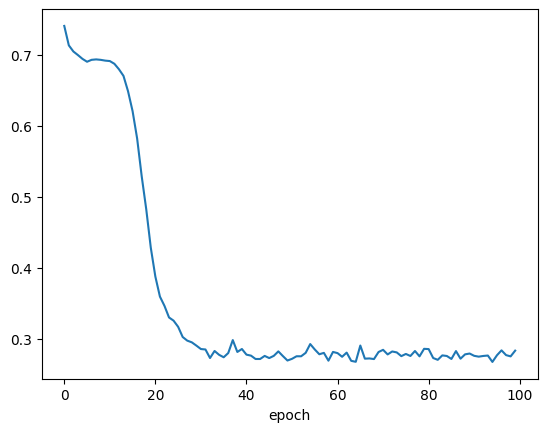

In [248]:
# # # Instantiate the model
# model = CNNModel2()

# # Define BCE loss and optimizer
# criterion = nn.BCELoss()
# optimizer = optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# # Number of training epochs
# epochs = 50

# # Call the training function
# average_loss = train_model(model, train_loader, criterion, optimizer, epochs, print_num=2)
# print(f"Average Training Loss: {average_loss}")
# # plt.yscale('log')
# plt.plot(average_loss)
# plt.xlabel("epoch")

#####

# Create the model, optimizer, and scheduler
model = CNNModel2()
#optimizer = torch.optim.Adam(model.parameters(), lr=0.02,weight_decay=0.001)

# Define RMSprop optimizer
# Define RMSprop optimizer
learning_rate=0.001

### best performance so far
optimizer = optim.Adam(model.parameters(), lr=0.0185, weight_decay=2*1e-4)#0.018 #0.0152# worked best so far, 0.013
### best one so far: 0.018



# optimizer=optim.RMSprop(model.parameters(), lr=0.0185, alpha=0.9)

# ## optimizer= optim.RMSprop(model.parameters(), lr=0.015, alpha=0.9)
#torch.optim.Adadelta(model.parameters(), lr=learning_rate)#optim.RMSprop(model.parameters(), lr=0.001, alpha=0.9)
#optimizer = optim.RMSprop(model.parameters(), lr=0.001, alpha=0.9)
#optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)# gamma 0.1

# # Define BCE loss
criterion = nn.BCELoss()
epochs=100

# Train the model with the scheduler
average_losses = train_model(model, train_loader, criterion, optimizer, scheduler, epochs=epochs, print_num=10)
#print(f"Average Training Loss: {average_loss}")
# plt.yscale('log')
plt.plot(average_losses)
plt.xlabel("epoch")

Text(0.5, 0, 'epoch')

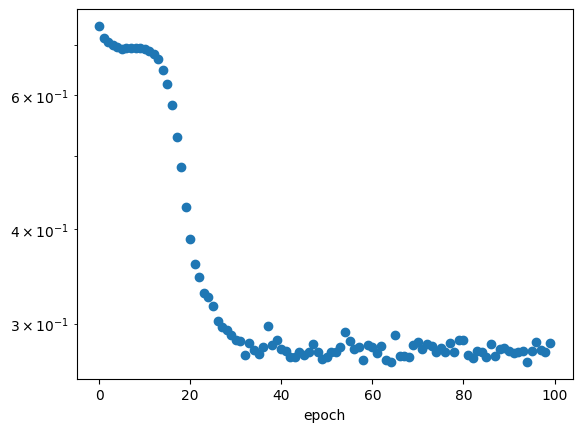

In [249]:
plt.yscale("log")
plt.plot(average_losses,"o")
plt.xlabel("epoch")

Text(0.5, 0, 'epoch')

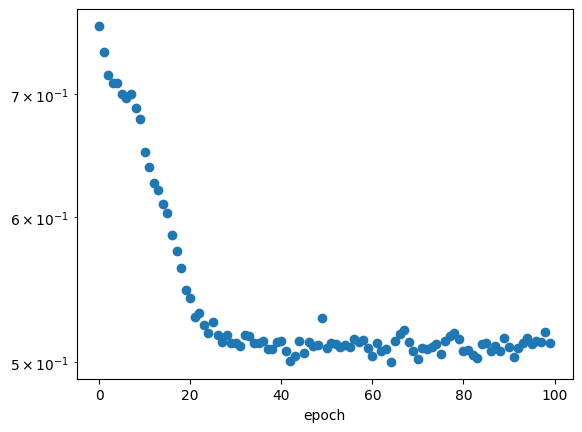

In [61]:
plt.yscale("log")
plt.plot(average_losses,"o")
plt.xlabel("epoch")

Text(0.5, 0, 'epoch')

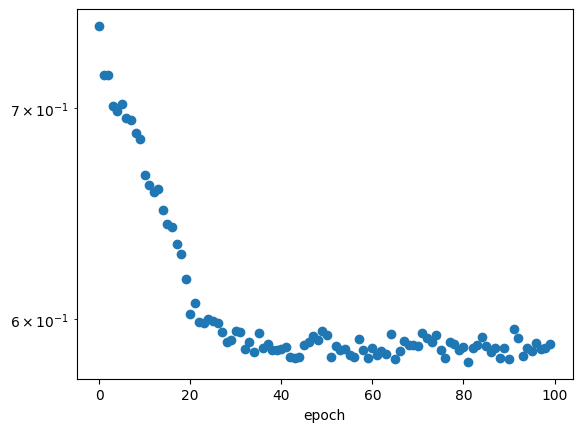

In [35]:
plt.yscale("log")
plt.plot(average_losses,"o")
plt.xlabel("epoch")

Text(0.5, 0, 'epoch')

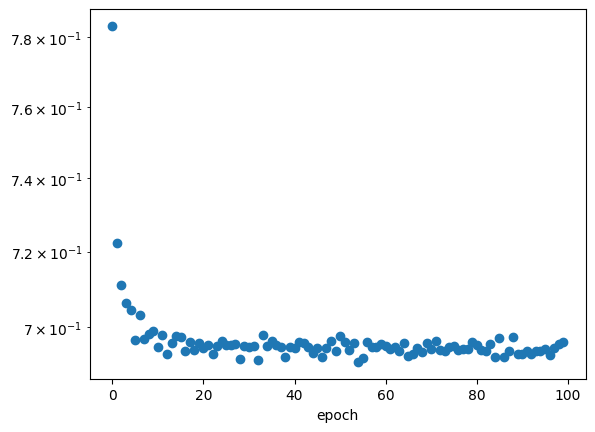

In [30]:
plt.yscale("log")
plt.plot(average_losses,"o")
plt.xlabel("epoch")

In [ ]:
# TODO: Train CNN

(d)

In [ ]:
# TODO: Evaluate CNN

In [ ]:
# TODO: Plot means and stds

# 3) Uncertainties in Amplitude Regression

In [ ]:
# download data to folder data04
# this might take some time (50MB)
# you can also do this manually (download + unpack zip)
import os, sys
import wget
from zipfile import ZipFile
from tqdm import tqdm

DESTINATION = "data04"
url = "https://www.thphys.uni-heidelberg.de/~plehn/pics/"
filename = "tutorial-2-data.zip"
url = url + filename

os.makedirs(DESTINATION, exist_ok=True)
os.chdir(DESTINATION)
wget.download(url, filename)
with ZipFile(filename, "r") as zip_ref:
    for file in tqdm(iterable=zip_ref.namelist(), total=len(zip_ref.namelist())):
        zip_ref.extract(member=file)
%ls
os.chdir("..")

In [ ]:
# load data
trn_dat = np.load("data04/tutorial-2-data/trn_dat.npy")
trn_amp = np.load("data04/tutorial-2-data/trn_amp.npy")

val_dat = np.load("data04/tutorial-2-data/val_dat.npy")
val_amp = np.load("data04/tutorial-2-data/val_amp.npy")

tst_dat = np.load("data04/tutorial-2-data/tst_dat.npy")
tst_amp = np.load("data04/tutorial-2-data/tst_amp.npy")

print(f"train data shape: {trn_dat.shape}")
print(f"train amp  shape: {trn_amp.shape}")
print(f"test  data shape: {tst_dat.shape}")
print(f"test  amp  shape: {tst_amp.shape}")
print(f"val   data shape: {val_dat.shape}")
print(f"val   amp  shape: {val_amp.shape}")

(a)

In [ ]:
# TODO: Recycle code from last sheet

In [ ]:
# TODO: Train ensemble of deterministic networks

In [ ]:
# TODO: Evaluate ensemble -> List of predictions for log A
# result: array preds of shape (10, 30000)

In [ ]:
# uncertainties at event level

preds_means = np.mean(np.log(preds), axis=0)
preds_stds = np.std(np.log(preds), axis=0)

plt.hist(np.log(tst_amp), range=(-20, -8), bins=50, alpha=.5)
plt.hist(preds_means, range=(-20, -8), bins=50, alpha=.5)
plt.xlabel(r"$\log A$")
plt.ylabel("bin height")
plt.show()

x = range(len(tst_amp))
plt.fill_between(x, preds_stds, -preds_stds, color="y", label=r"predicted $\sigma_{\log A}$")
plt.plot(x, preds_means - np.log(tst_amp), ",", alpha=.5, ms=.1, label=r"$\log A_\mathrm{pred}-\log A_\mathrm{true}$")
plt.xlabel("# event")
plt.ylim(-1,1)
plt.legend()
plt.show()

# TODO: Interpret results

In [ ]:
# uncertainties at histogram level

hist_test, bins = np.histogram(np.log(tst_amp), range=(-20,-8), bins=50)
hist_data = np.array([np.histogram(np.log(preds[i,:]), bins=bins)[0] for i in range(n_models)])
hist_means = np.mean(hist_data, axis=0)
hist_stds = np.std(hist_data, axis=0)

# means
dup_last = lambda a: np.append(a, a[-1])
plt.step(bins, dup_last(hist_test), label="test")
plt.step(bins, dup_last(hist_means), label="ensemble")
plt.xlabel(r"$\log A$")
plt.ylabel("bin height")
plt.legend()
plt.show()

# standard deviations
plt.step(bins, dup_last(np.sqrt(hist_means)), label="statistical uncertainty")
plt.step(bins, dup_last(hist_stds), label="ensemble uncertainty")
plt.xlabel(r"$\log A$")
plt.ylabel("bin standard deviation")
plt.legend()
plt.show()

# means + standard deviations
hists = [hist_test, hist_means]
hist_errors = [np.sqrt(hist_test), hist_stds]
integrals = [np.sum((bins[1:] - bins[:-1])*y) for y in hists]
scales = [1 / integral if integral != 0. else 1. for integral in integrals]

label = ["Test", "ensemble"]
fig, axs = plt.subplots(2, 1, sharex=True, gridspec_kw={"height_ratios": [3, 1], "hspace": 0.})
for y, y_err, scale, label in zip(hists, hist_errors, scales, label):
    axs[0].step(bins, dup_last(y) * scale, label=label, where="post")
    axs[0].fill_between(bins, dup_last(y + y_err) * scale,
                     dup_last(y - y_err) * scale, alpha=.5, step="post")

    ratio = (y * scale) / (hists[0] * scales[0])
    ratio_err = np.sqrt( (y_err/y)**2 + (hist_errors[0] / hists[0])**2)
    ratio[np.isnan(ratio)] = 1.
    ratio_err[np.isnan(ratio)] = 0.

    axs[1].step(bins, dup_last(ratio), where="post")
    axs[1].fill_between(bins, dup_last(ratio + ratio_err), dup_last(ratio - ratio_err), step="post", alpha=.5)
axs[1].set_xlabel(r"$\log A$")
axs[0].set_ylabel("Normalized")
axs[1].set_ylabel(r"$\frac{\mathrm{Ensemble}}{\mathrm{Test}}$")
axs[1].set_ylim(.5, 1.5)
axs[0].legend()
plt.show()

# TODO: Interpret results

(d)

In [ ]:
# TODO: Fill in expression for KL divergence
import math

class VBLinear(nn.Module):
    # VB = variational bayes
    def __init__(self, in_features, out_features, prior_prec=1.0, _map=False, std_init=-5):
        super(VBLinear, self).__init__()
        self.n_in = in_features
        self.n_out = out_features
        self.map = _map
        self.prior_prec = prior_prec # = 1/sigma_prior**2
        self.random = None
        self.bias = nn.Parameter(torch.Tensor(out_features))
        self.mu_w = nn.Parameter(torch.Tensor(out_features, in_features))
        self.logsig2_w = nn.Parameter(torch.Tensor(out_features, in_features)) # log(sigma_network**2)
        self.std_init = std_init
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.mu_w.size(1))
        self.mu_w.data.normal_(0, stdv)
        self.logsig2_w.data.zero_().normal_(self.std_init, 0.001)
        self.bias.data.zero_()

    def KL(self):
        logsig2_w = self.logsig2_w.clamp(-11, 11)
        kl = None # KL divergence of variational bayes linear layer
        return kl

    def forward(self, input):
        if self.training:
            # local reparameterization trick is more efficient and leads to
            # an estimate of the gradient with smaller variance.
            # https://arxiv.org/pdf/1506.02557.pdf
            mu_out = nn.functional.linear(input, self.mu_w, self.bias)
            logsig2_w = self.logsig2_w.clamp(-11, 11)
            s2_w = logsig2_w.exp()
            var_out = nn.functional.linear(input.pow(2), s2_w) + 1e-8
            return mu_out + var_out.sqrt() * torch.randn_like(mu_out)

        else:
            if self.map: # just return the mean, no sampling
                return nn.functional.linear(input, self.mu_w, self.bias)

            logsig2_w = self.logsig2_w.clamp(-11, 11)
            if self.random is None:
                self.random = torch.randn_like(self.logsig2_w)
            s2_w = logsig2_w.exp()
            weight = self.mu_w + s2_w.sqrt() * self.random
            return nn.functional.linear(input, weight, self.bias) + 1e-8

In [ ]:
# TODO: Create BNN (like deterministic network, but with bayesian layers)

class bayesian_amp_net(nn.Module):

    def __init__(self, training_size, ipt_dim=20, opt_dim=1, hdn_dim=32, n_layers=2):
        pass

    def forward(self, x):
        pass

    def KL(self):
        kl = 0
        for layer in self.bayesian_layers:
            kl += layer.KL()
        return kl

    def reset_BNN(self):
        for layer in self.bayesian_layers:
            layer.random = None

In [ ]:
def batch_loss_bayesian(model, x, y):
    x, y = x.to(device), y.to(device)
    pred = model(x)
    loss = loss_fn(pred, y)
    kl = model.KL() / trn_dat.shape[0] # correct normalization!
    loss += kl
    return loss

In [ ]:
# TODO: Train BNN

(e)

In [ ]:
# TODO: Evaluate BNN

In [ ]:
# uncertainties at event level

preds_means = np.mean(np.log(preds), axis=0)
preds_stds = np.std(np.log(preds), axis=0)

plt.hist(np.log(tst_amp), range=(-20, -8), bins=50, alpha=.5)
plt.hist(preds_means, range=(-20, -8), bins=50, alpha=.5)
plt.xlabel(r"$\log A$")
plt.ylabel("bin height")
plt.show()

x = range(len(tst_amp))
plt.fill_between(x, preds_stds, -preds_stds, color="y", label=r"predicted $\sigma_{\log A}$")
plt.plot(x, preds_means - np.log(tst_amp), ",", alpha=.5, ms=.1, label=r"$\log A_\mathrm{pred}-\log A_\mathrm{true}$")
plt.xlabel("# event")
plt.ylim(-1,1)
plt.legend()
plt.show()

# TODO: Interpret results

In [ ]:
# uncertainties at histogram level

hist_test, bins = np.histogram(np.log(tst_amp), range=(-20,-8), bins=50)
hist_data = np.array([np.histogram(np.log(preds[i,:]), bins=bins)[0] for i in range(n_models)])
hist_means = np.mean(hist_data, axis=0)
hist_stds = np.std(hist_data, axis=0)

# means
dup_last = lambda a: np.append(a, a[-1])
plt.step(bins, dup_last(hist_test), label="test")
plt.step(bins, dup_last(hist_means), label="ensemble")
plt.xlabel(r"$\log A$")
plt.ylabel("bin height")
plt.legend()
plt.show()

# standard deviations
plt.step(bins, dup_last(np.sqrt(hist_means)), label="statistical uncertainty")
plt.step(bins, dup_last(hist_stds), label="ensemble uncertainty")
plt.xlabel(r"$\log A$")
plt.ylabel("bin standard deviation")
plt.legend()
plt.show()

# means + standard deviations
hists = [hist_test, hist_means]
hist_errors = [np.sqrt(hist_test), hist_stds]
integrals = [np.sum((bins[1:] - bins[:-1])*y) for y in hists]
scales = [1 / integral if integral != 0. else 1. for integral in integrals]

label = ["Test", "ensemble"]
fig, axs = plt.subplots(2, 1, sharex=True, gridspec_kw={"height_ratios": [3, 1], "hspace": 0.})
for y, y_err, scale, label in zip(hists, hist_errors, scales, label):
    axs[0].step(bins, dup_last(y) * scale, label=label, where="post")
    axs[0].fill_between(bins, dup_last(y + y_err) * scale,
                     dup_last(y - y_err) * scale, alpha=.5, step="post")

    ratio = (y * scale) / (hists[0] * scales[0])
    ratio_err = np.sqrt( (y_err/y)**2 + (hist_errors[0] / hists[0])**2)
    ratio[np.isnan(ratio)] = 1.
    ratio_err[np.isnan(ratio)] = 0.

    axs[1].step(bins, dup_last(ratio), where="post")
    axs[1].fill_between(bins, dup_last(ratio + ratio_err), dup_last(ratio - ratio_err), step="post", alpha=.5)
axs[1].set_xlabel(r"$\log A$")
axs[0].set_ylabel("Normalized")
axs[1].set_ylabel(r"$\frac{\mathrm{Ensemble}}{\mathrm{Test}}$")
axs[1].set_ylim(.5, 1.5)
axs[0].legend()
plt.show()

# TODO: Interpret results